# ML Process - Air Quality
---

**2 - Data Understanding (EDA)**

In [1]:
# Import the required libraries.
import yaml
import joblib
import numpy as np
import pandas as pd

# need to be installed 
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt

## 1 - Configuration File

---

Fungsinya masih sama dengan yang `data_pipeline`, jadi bisa langsung di *copy-paste* disini. Tidak ada yang perlu diubah kok

In [2]:
# Function to load configuration parameter.
def load_config(path_config):
    """
    Load the configuration file (config.yaml).

    Parameters:
    ----------
    path_config : str
        Configuration file location.

    Returns:
    -------
    params : dict
        The configuration parameters.
    """

    # Try to load config.yaml file.
    try:
        with open(path_config, 'r') as file:
            params = yaml.safe_load(file)
    except FileNotFoundError as err:
        raise RuntimeError(f"Configuration file not found in {path_config}")

    return params

In [3]:
# load the configuration file
PATH_CONFIG = "../config/config.yaml"
config = load_config(PATH_CONFIG)

In [4]:
# check the configuration parameters
config

{'columns_object': ['stasiun', 'critical', 'category'],
 'datetime_columns': ['tanggal'],
 'features': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'category',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'object_columns': ['stasiun', 'critical', 'category'],
 'path_joined_data': '../data/interim/joined_dataset.pkl',
 'path_raw_data': '../data/raw/',
 'path_test_set': ['../data/interim/X_test.pkl', '../data/interim/y_test.pkl'],
 'path_train_set': ['../data/interim/X_train.pkl',
  '../data/interim/y_train.pkl'],
 'path_valid_set': ['../data/interim/X_valid.pkl',
  '../data/interim/y_valid.pkl'],
 'path_validated_data': '../data/interim/validated_data.pkl',
 'range_co': [-1, 47],
 'range_no2': [-1, 65],
 'range_o3': [-1, 151],
 'range_pm10': [-1, 179],
 'range_pm25': [-1, 174],
 'range_so2': [-1, 82],
 'range_stasiun': ['DKI1 (Bunderan HI)

perbedaan dari config sebelumnya adalah yang paling mencolok :
- 'path_test_set': ['../data/interim/X_test.pkl', '../data/interim/y_test.pkl'],
- 'path_train_set': ['../data/interim/X_train.pkl', '../data/interim/y_train.pkl'],
- 'path_valid_set': ['../data/interim/X_valid.pkl',  '../data/interim/y_valid.pkl'],

lalu ada juga pada bagian range :
- 'range_co': [-1, 47],
- 'range_no2': [-1, 65],
- 'range_o3': [-1, 151],
- 'range_pm10': [-1, 179],
- 'range_pm25': [-1, 174],
- 'range_so2': [-1, 82],
- 'range_stasiun': ['DKI1 (Bunderan HI)',  'DKI2 (Kelapa Gading)',  'DKI3 (Jagakarsa)',  'DKI4 (Lubang Buaya)',  'DKI5 (Kebon Jeruk) Jakarta Barat']}

Itu tandanya configuration sebelumnya sudah berhasil.

## 2 - Load Data

---

**Note**: Do EDA only on the train set.

In [5]:
# load the train set
X_train = joblib.load(config['path_train_set'][0])
y_train = joblib.load(config['path_train_set'][1])

**Kenapa menggunakan `joblib.load()` bukan `read_csv`?**

jadi di proces sebelumnya, yaitu data_pipeline, kita sudah mengubah bentuk file yang awalnya Data Frame menjadi bentuk binary (Serialize), bisa cek code berikut di `data_pipeline` sebelumnya : 

```python
PATH_SPLITTED_DATA = f"../data/interim/"

joblib.dump(X_train, f"{PATH_SPLITTED_DATA}X_train.pkl")
joblib.dump(y_train, f"{PATH_SPLITTED_DATA}y_train.pkl")
joblib.dump(X_valid, f"{PATH_SPLITTED_DATA}X_valid.pkl")
joblib.dump(y_valid, f"{PATH_SPLITTED_DATA}y_valid.pkl")
joblib.dump(X_test, f"{PATH_SPLITTED_DATA}X_test.pkl")
joblib.dump(y_test, f"{PATH_SPLITTED_DATA}y_test.pkl")
```

dan kita juga sudah meng-*update* itu ke config file berikut :

```python
# Update the configuration parameters.
config = update_config(
    key = "path_train_set",
    value = [f"{PATH_SPLITTED_DATA}X_train.pkl", f"{PATH_SPLITTED_DATA}y_train.pkl"],
    params = config,
    path_config = PATH_CONFIG
)

config = update_config(
    key = "path_valid_set",
    value = [f"{PATH_SPLITTED_DATA}X_valid.pkl", f"{PATH_SPLITTED_DATA}y_valid.pkl"],
    params = config,
    path_config = PATH_CONFIG
)

config = update_config(
    key = "path_test_set",
    value = [f"{PATH_SPLITTED_DATA}X_test.pkl", f"{PATH_SPLITTED_DATA}y_test.pkl"],
    params = config,
    path_config = PATH_CONFIG
)
```

Maka kalo kita cek di config file : 

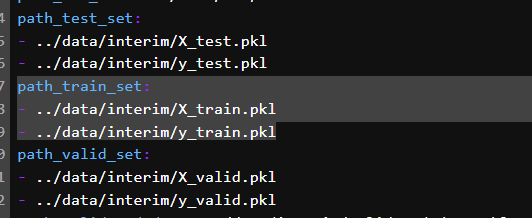

kita sudah menyimpannya di folder `data/interim` :

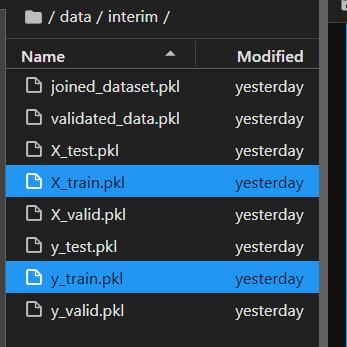

Dan yang terakhir, apa sih maksud dari : 

```python
# load the train set
...(config['path_train_set'][0])
...(config['path_train_set'][1])
```

Jadi [0] dan [1] merujuk pada urutan list pada config file, kalo kita lihat lagi 

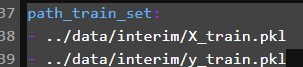

`index-0` merujuk pada `X_train` dan `index-1` merujuk pada `y_train`

**Lalu kenapa kita hanya menggunakan data train?**

Ya intinya biar kita ga ngasih contekan ke data alias data leakage. 

Ibaratnya tuh kaya, 
- `Data Train` tuh soal ujian yang udah disiapkan kunci jawabannya.
- Lalu `Data Validation` tuh soal-soal try-out, semi-ujian, jadi kaya simulasi gitu.
- Nah yang terakhir `Data Test`, ini soal ujian sesungguhnya, ibaratnya kalo dulu tuh UN (Ujian Nasional). Kalo kita EDA menggunakan Data Validation atau Data Test, itu sama aja kaya kita ngasih bocoran soal ke Model

Nah karena kita tahu banyak Data Train tuh sekitar 70-80%, kita pengen model kedepannya tuh latihan berdasarkan soal yang berbeda-beda, kalo kita kasih soal dari `Data Test` yang ukurannya hanya 10-20%, **takutnya model hanya menghafal**, bukan memahami data.

In [6]:
# join data X_train and y_train

dataset = pd.concat(
    [X_train, y_train],
    axis=1
)

 Jangan lupa untuk diberi `axis=1`, kalo ga nanti ga bakal berhasil kaya gini :

 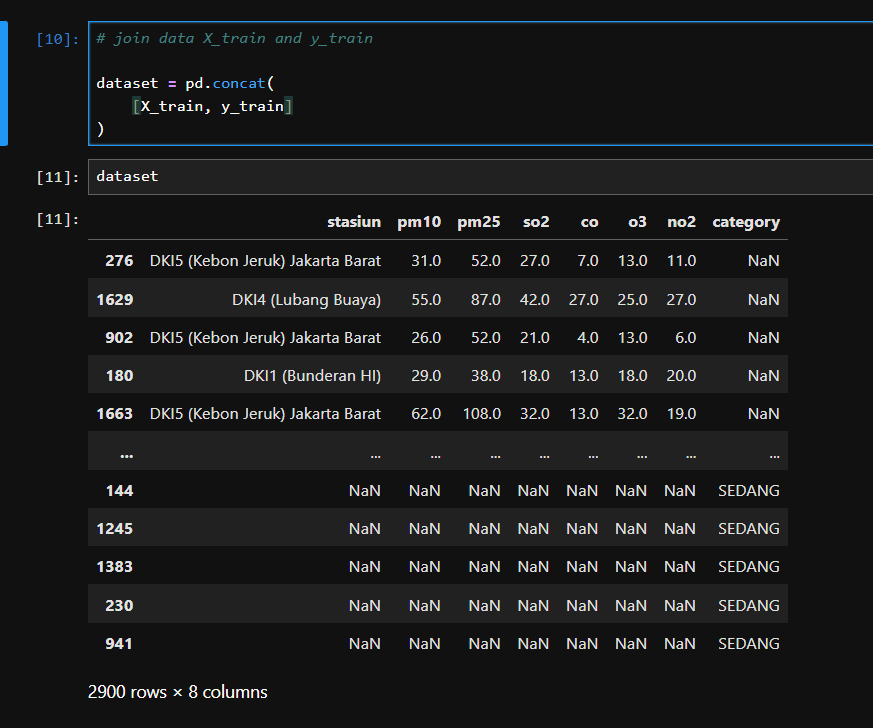

In [7]:
# check the join dataset
dataset

,stasiun,pm10,pm25,so2,co,o3,no2,category
276,DKI5 (Kebon Jeruk) Jakarta Barat,31,52,27,7,13,11,SEDANG
1629,DKI4 (Lubang Buaya),55,87,42,27,25,27,SEDANG
902,DKI5 (Kebon Jeruk) Jakarta Barat,26,52,21,4,13,6,SEDANG
180,DKI1 (Bunderan HI),29,38,18,13,18,20,BAIK
1663,DKI5 (Kebon Jeruk) Jakarta Barat,62,108,32,13,32,19,TIDAK SEHAT
...,...,...,...,...,...,...,...,...
144,DKI5 (Kebon Jeruk) Jakarta Barat,42,70,-1,7,34,14,SEDANG
1245,DKI1 (Bunderan HI),52,72,28,6,28,19,SEDANG
1383,DKI1 (Bunderan HI),36,57,15,15,26,13,SEDANG
230,DKI3 (Jagakarsa),45,59,25,13,29,15,SEDANG


## 3 - Exploreratory Data Analysis

---

1. Missing Value Check
2. Skewness Check
3. Data Split
4. Visualization
5. Hypotesis Test
6. Imbalanced Label Check
7. Outliers Check

---

### 3.1 Missing Value Check

In [8]:
# Replace the -1 with NaN
dataset = dataset.replace(-1, np.nan)

In [9]:
# check the number of missing value.
dataset.isnull().sum()

stasiun      0
pm10        43
pm25        75
so2         79
co          14
o3          39
no2         18
category     0
dtype: int64

Kalo kita lihat sekilas, `data missing value`-nya tiap fitur ga terlalu banyak kalo dibandingkan dengan total `data train` yang totalnya `1450 rows`. Tapi mau bagaimana pun harus kita handling karena informasi sekecil apapun akan berguna buat `modelling` kedepannya.

---

### 3.2 Skewness Check

Langkah selanjutnya kita bisa mengecek `skewness`-nya. Skewness itu kaya tingkat distribusi datanya ketarik ke-arah kanan atau kiri. itu biasanya karena ada outliers. 

Kalo ada outliers yang terlalu besar, itu bisa ngarah persebaran distribusinya ke kanan. Begitu pun sebaliknya, kalo ada outliers yang angkanya terlalu kecil atau bahkan minus, distribusi data cenderung ngarah ke kiri. 

Nah `Pandas` sendiri punya method bawaan untuk mengecek skewness menggunakan `.skew` dari Fisher Pearson.

In [10]:
# Fisher Pearson Skew Value
dataset.skew(numeric_only=True)

pm10    0.184220
pm25    0.277752
so2     0.146916
co      1.796021
o3      1.427239
no2     0.856749
dtype: float64

**Insight:** 

- `co`, `o3`, and `no2` memiliki hasil skew diatas $> 0.5$ dari batas nilai utama 0. Yang mengindikasikan adanya outliers. Kita akan inputasi skew tersebut menggunakan nilai tengah `median`.
- untuk sisanya (`pm10`, `pm25`, dan `so2`) akan kita inputasi menggunakan rata-rata atau mean. Karena masih $< 0.5$ dari 0

---

### 3.3 Data Split

Split Data Berdasarkan Kelas

Nah mungkin ini sedikit berbeda dari apa yang sudah dipelajari di `Intro ML`, jadi bisa dikatakan ini adalah jenis **Data Split yang baru**. Jadi ini kita split beradasarkan kelasnya, atau berdasarkan labelnya. 

Hmm.. biasanya kita kalo split itu :
- Input & Output. Dimana X dan Y nya kita pisah
- Train, Valid, Test.
- Numerik dengan Categorikal
- Nah yang sekarang, beradaskan Kelas-nya atau Labelnya.

Jadi yang sekarang kita akan split berdasarkan kelas-nya untuk mmengecek **apakah perbedaan kelas/label itu berbeda distribusinya?**

In [11]:
dataset_baik = dataset[dataset["category"] == "BAIK"].copy()
dataset_tidak_baik = dataset[dataset["category"] != "BAIK"].copy()

Kenapa yang satu menggunakan `== "BAIK"` dan yang satu menggunakan `!= "BAIK"`? Karena kalo kita cek, sebenernya category ada `BAIK`, `SEDANG`, dan `TIDAK BAIK`. Kalo kita cek manual :

In [12]:
dataset["category"].value_counts()

category
SEDANG         1044
TIDAK SEHAT     255
BAIK            151
Name: count, dtype: int64

Nah biar kita ga perlu setting 2x yang `dataset_tidak_baik = category == SEDANG` dan `dataset_tidak_baik = category == TIDAK BAIK`, kita langsung saja menggunakan `!=` untuk mempercepat code. Toh juga **apapun itu selain BAIK akan dimasukan kedalam `dataset_tidak_baik`**.

In [13]:
# kelas 1 => BAIK
dataset_baik.describe()

,pm10,pm25,so2,co,o3,no2
count,143.000000,107.000000,147.000000,151.000000,148.000000,141.000000
mean,28.419580,39.252336,25.517007,8.986755,26.472973,10.773050
std,7.789857,8.086902,10.729140,4.479564,11.349995,6.541482
min,14.000000,13.000000,3.000000,2.000000,7.000000,3.000000
25%,23.000000,34.000000,17.500000,6.000000,16.000000,6.000000
50%,28.000000,40.000000,23.000000,8.000000,25.500000,9.000000
75%,33.000000,46.500000,36.000000,11.000000,36.000000,15.000000
max,50.000000,50.000000,50.000000,28.000000,49.000000,49.000000


In [14]:
dataset_tidak_baik.describe()

,pm10,pm25,so2,co,o3,no2
count,1264.000000,1268.000000,1224.000000,1285.000000,1263.000000,1291.000000
mean,55.579114,82.754732,36.763072,11.957198,32.683294,20.295895
std,13.202008,22.089020,12.251497,4.881034,14.508900,8.725840
min,19.000000,19.000000,5.000000,3.000000,9.000000,1.000000
25%,49.000000,68.000000,27.000000,9.000000,23.000000,14.000000
50%,55.000000,81.000000,37.000000,11.000000,29.000000,19.000000
75%,63.000000,96.000000,46.000000,14.000000,39.000000,25.500000
max,179.000000,161.000000,81.000000,47.000000,151.000000,65.000000


---

Kalo kita lihat hasil dari `mean` pada fitur `pm10` dan juga `pm25` terlihat perbedaan angkanya jauh / signifikan :
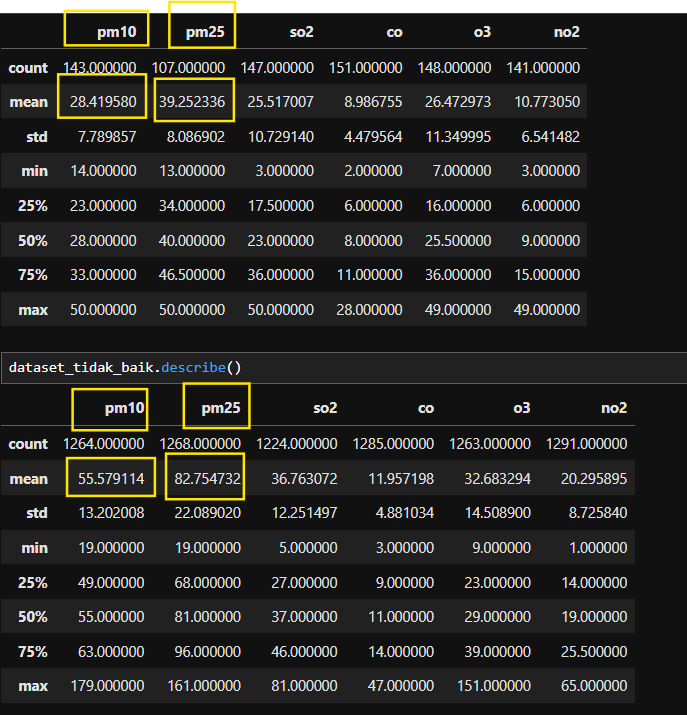

- `dataset_baik` pada fitur `pm10` memiliki nilai *mean* / rata-rata `28.4`, sedangkan pada `dataset_tidak_baik` pada fitur `pm10` memiliki nilai *mean* `55.5`, ada **perbedaan sebanyak 27 angka**
- begitupun pada `dataset_baik` fitur `pm25` *mean* : `39.2` sedangkan pada `dataset_tidak_baik` *mean* : `82.7`, **perbedaannya sebanyak `49`**.

---

Sedangkan pada fitur lain seperti `so2`, `co`, `o3` dan `no2` perbedaan mean-nya tidak terlalu jauh : 

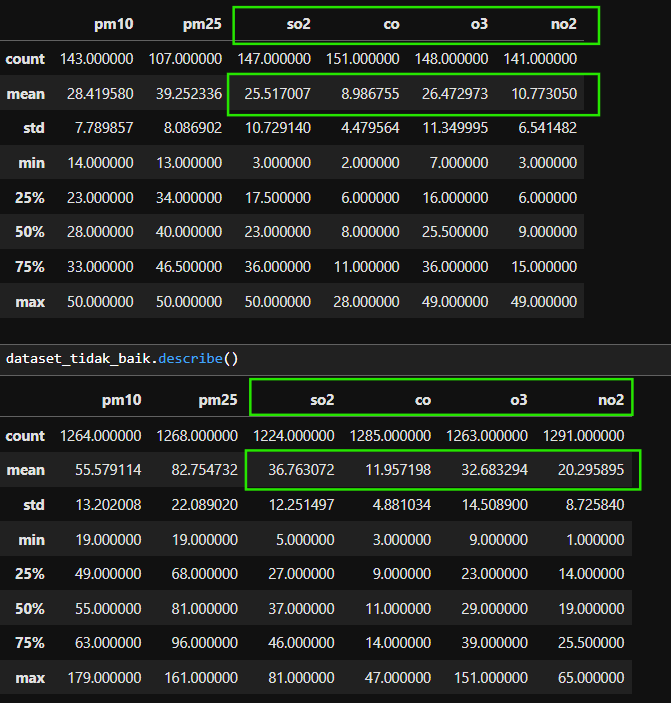

Karena perbedaan kurang lebih hanya 10, maka `so2`, `co`, `o3` dan `no2` masih dibilang mirip-mirip atau tidak terlalu jauh.

**Kesimpulan**

- `pm10` dan `pm25` rata-ratanya diantara kelas 0 (Baik) dan kelas 1 (Tidak Baik) cukup signifikan, kita akan melakukan inputas rata-rata kelas.
- `so2` rata-ratanya diatara kelas 0 dan 1 tidak terlalu jauh, maka kita akan inputasi menggunakan mean.
- karena tadi fitur `co`, `o3` dan `no2`terdeteksi ada outliers, kita akan inputasi menggunakan median.

---

### 3.4 Visualization

Untuk mengecek apakah pada step-step sebelumnya itu benar? kita perlu visualisasi untuk mengecek kebenaran tersebut. **Apakah *mean* / rata-rata tiap fitur pada kelas 0 dan 1 berbeda jauh atau tidak?**

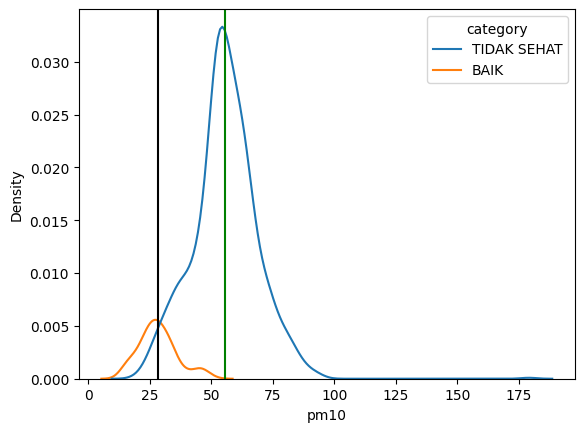

In [15]:
# pm10 column distribution 

sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "pm10",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["pm10"].mean(), 0, 1, color="g")
plt.axvline(dataset_baik["pm10"].mean(), 0, 1, color="k")
plt.show()

Bisa dilihat, *mean* / rata-rata dari `pm10` berbeda siginifikan.

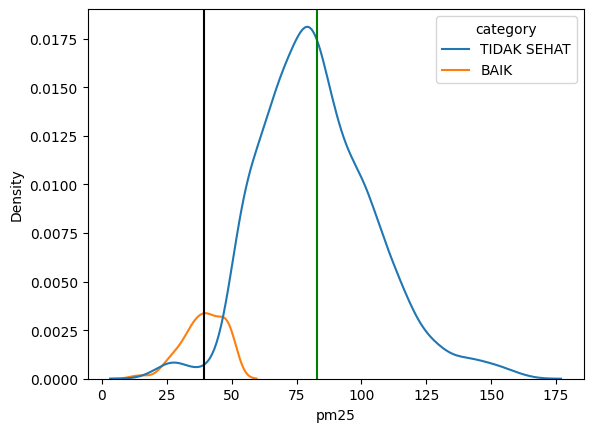

In [16]:
# pm10 column distribution 

sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "pm25",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["pm25"].mean(), 0, 1, color="g")
plt.axvline(dataset_baik["pm25"].mean(), 0, 1, color="k")
plt.show()

di `pm25` juga *mean*-nya berbeda signifikan

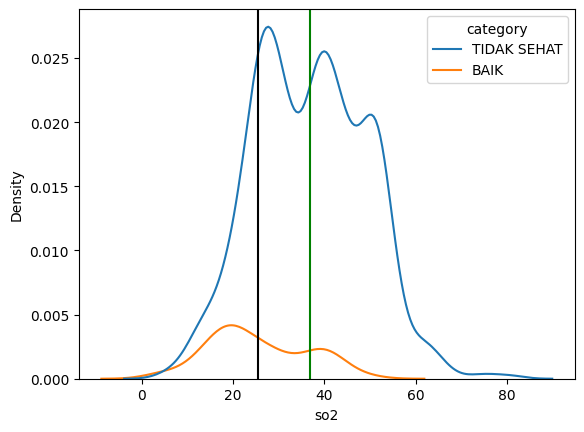

In [17]:
# pm10 column distribution 

sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "so2",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["so2"].mean(), 0, 1, color="g")
plt.axvline(dataset_baik["so2"].mean(), 0, 1, color="k")
plt.show()

Seperti di `.descriptive` jika rata-rata `so2` antara category `BAIK` dan `TIDAK BAIK` tidak terlalu signifikan, hasil visualisasi juga menyatakan hal yang sama.

Untuk `co`, `o3` dan `no2` akan menggunakan median karena tadi kita sudah mengecek jika kolom / fitur tersebut terdapat outliers.

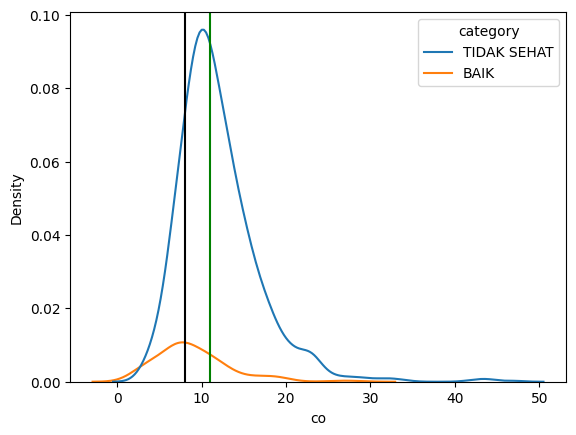

In [18]:
# pm10 column distribution 

sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "co",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["co"].median(), 0, 1, color="g")
plt.axvline(dataset_baik["co"].median(), 0, 1, color="k")
plt.show()

bisa kita lihat, memang median antara category `BAIK` dan `TIDAK SEHAT` tidak terlalu jauh. Namun juga bisa kita lihat terdapat outliers yang begitu jauh dari median

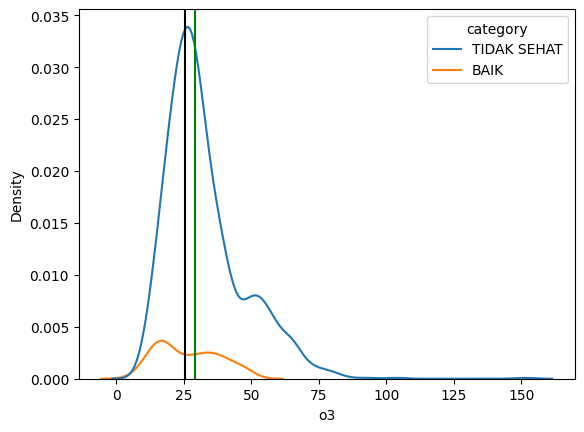

In [19]:
# pm10 column distribution 

sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "o3",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["o3"].median(), 0, 1, color="g")
plt.axvline(dataset_baik["o3"].median(), 0, 1, color="k")
plt.show()

disini selisihnya dekat sekali 

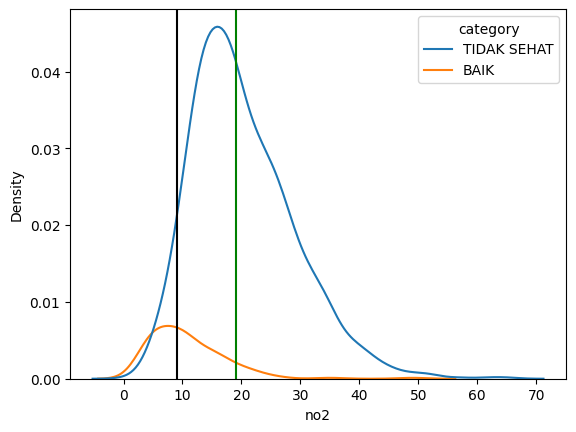

In [20]:
# pm10 column distribution 

sns.kdeplot(
    data = dataset.replace("SEDANG", "TIDAK SEHAT"),
    x = "no2",
    hue = "category"
)
plt.axvline(dataset_tidak_baik["no2"].median(), 0, 1, color="g")
plt.axvline(dataset_baik["no2"].median(), 0, 1, color="k")
plt.show()

disini tidak terlalu jauh

**Correlation**

Sebenarnya sudah cukup untuk melihat jarak mean dan median dari tiap kategori, hanya saja kita juga bisa mengecek korelasi antar fiturnya seperti apa.

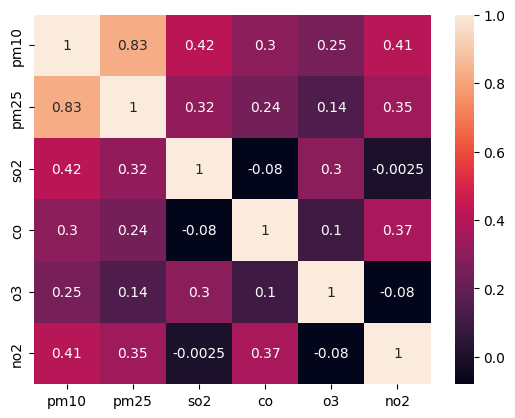

In [21]:
# Pearson Correlation
sns.heatmap(
    dataset.corr(numeric_only=True),
    annot=True
)
plt.show()

Disini, kalo diperhatikan ada **multicorreality**, yang terjadi di `pm10` dan `pm25`. Jadi *multicorreality* kondisi ketika korelasi antar fitur dia relatif besar, entah itu mendekati -1 atau +1. 

- *Dan apa efeknya terhadap model?*
- Bisa jadi menurunkan performa model
- *Lalu bagaimana caranya meng-handle *multicorreality* ini?*
- Kita bisa menggunakan teknik *Reguralization*. Tapi kalo ternyata kalo ga kita handel dan pas kita latih model hasilnya masih bisa kita maklumi dan masih relevan, ya sebetulnya ga di *Reguralization* gapapa. Selama ga ada pertimbangan hal lain gapapa ga di-*handle*.

---

### 3.5 Hypotesis Test 

T-Test (Untuk mengecek rata-rata 2 variable)

**Catatan** :
- $h_0$ (null hypotesis) : *mean* / rata-rata kelas 0 == *mean* / rata-rata kelas 1.
- $h_1$ (alternative hypotesis) : *mean* / rata-rata kelas 0 != *mean* / rata-rata kelas 1.
- $h_0$ dan $h_1$ *mutually exclusive* (jika $h_0$ *True*, maka $h_1$ *False*, dan kebalikannya)
- Tujuan dari Test ini adalah untuk membuktikan jika $h_0$ di tolak.

**Catatan :** 
- jika $t_{value} < t_{critical}$ dan $p_{value} < 0.05$, maka $h_0$ ditolak.

---

**pm10**

In [22]:
# pm10 t-value
scs.ttest_ind(
    dataset_baik[dataset_baik["pm10"].isnull() != True].pm10,
    dataset_tidak_baik[dataset_tidak_baik["pm10"].isnull() != True].pm10
)

TtestResult(statistic=np.float64(-24.12545179265497), pvalue=np.float64(7.027165495474983e-108), df=np.float64(1405.0))

In [23]:
# t-critical for alpha = 0.05 and dof= n- 2 (default)
scs.t.ppf(0.05, df=(len(dataset) -2))

np.float64(-1.6459066313849768)

**Hasil :**
- $t_{value} = -24.12545179265497$
- $t_{critical} = -1.6459066313849768$
- $p_{value} = 7.027165495474983e-108$ atau $7.027 \times 10^{-108}$ atau $\frac{7,02}{10^{108}}$

**Maka :**
- $t_{value} < t_{critical}$, karena :
    - $-24.12545179265497 < -1.6459066313849768$.
- dan $p_{value} < 0.05$, karena :
    - $7.027165495474983e-108$ atau $7.027 \times 10^{-108}$ atau $\frac{7,02}{10^{108}}$, dimana masih $< 0.05$.
- $h_0$ ditolak

Jadi, **hipotesisnya jika rata-rata kelas `BAIK` dan `TIDAK BAIK` sama, tidak terbukti secara statistik.**

---

**pm25**

In [24]:
# pm25 t-value
scs.ttest_ind(
    dataset_baik[dataset_baik["pm25"].isnull() != True].pm25,
    dataset_tidak_baik[dataset_tidak_baik["pm25"].isnull() != True].pm25
)

TtestResult(statistic=np.float64(-20.25174385665515), pvalue=np.float64(5.2999355647762365e-80), df=np.float64(1373.0))

$$\frac{7,02}{10^{108}}$$

**Hasil :**
- $t_{value} = -20.25174385665515$
- $t_{critical} = -1.6459066313849768$
- $p_{value} = 5.2999355647762365e-80$ atau $5.299 \times 10^{-80}$ atau $\frac{5,29}{10^{80}}$

**Maka :**
- $t_{value} < t_{critical}$, karena :
    - $-20.25174385665515 < -1.6459066313849768$.
- dan $p_{value} < 0.05$, karena :
    - $5.2999355647762365e-80$ atau $5.299 \times 10^{-80}$ atau $\frac{5,29}{10^{80}}$, dimana masih $< 0.05$.
- $h_0$ ditolak

---

**so2**

In [25]:
# so2 t-value
scs.ttest_ind(
    dataset_baik[dataset_baik["so2"].isnull() != True].so2,
    dataset_tidak_baik[dataset_tidak_baik["so2"].isnull() != True].so2
)

TtestResult(statistic=np.float64(-10.648978467546145), pvalue=np.float64(1.6993432245445057e-25), df=np.float64(1369.0))

**Hasil :**
- $t_{value} = -10.648978467546145$
- $t_{critical} = -1.6459066313849768$
- $p_{value} = 1.6993432245445057e-25$ atau $1.699 \times 10^{-25}$ atau $\frac{1,69}{10^{25}}$

**Maka :**
- $t_{value} < t_{critical}$, karena :
    - $-10.648978467546145 < -1.6459066313849768$.
- dan $p_{value} < 0.05$, karena :
    - $1.6993432245445057e-25$ atau $1.699 \times 10^{-25}$ atau $\frac{1,69}{10^{25}}$, dimana masih $< 0.05$.
- $h_0$ ditolak

---

**co**

In [26]:
# co t-value
scs.ttest_ind(
    dataset_baik[dataset_baik["co"].isnull() != True].co,
    dataset_tidak_baik[dataset_tidak_baik["co"].isnull() != True].co
)

TtestResult(statistic=np.float64(-7.133210565391606), pvalue=np.float64(1.5505391850692764e-12), df=np.float64(1434.0))

**Hasil :**
- $t_{value} = -7.133210565391606$
- $t_{critical} = -1.6459066313849768$
- $p_{value} = 1.5505391850692764e-12$ atau $1.550 \times 10^{-12}$ atau $\frac{1.55}{10^{12}}$

**Maka :**
- $t_{value} < t_{critical}$, karena :
    - $-7.133210565391606 < -1.6459066313849768$.
- dan $p_{value} < 0.05$, karena :
    - $1.5505391850692764e-12$ atau $1.550 \times 10^{-12}$ atau $\frac{1.55}{10^{12}}$, dimana masih $< 0.05$.
- $h_0$ ditolak

---

**o3**

In [27]:
# o3 t-value
scs.ttest_ind(
    dataset_baik[dataset_baik["o3"].isnull() != True].o3,
    dataset_tidak_baik[dataset_tidak_baik["o3"].isnull() != True].o3
)

TtestResult(statistic=np.float64(-5.029472914936059), pvalue=np.float64(5.550659557355556e-07), df=np.float64(1409.0))

**Hasil :**
- $t_{value} = -5.029472914936059$
- $t_{critical} = -1.6459066313849768$
- $p_{value} = 5.550659557355556e-07$ atau $5.550 \times 10^{-7}$ atau $\frac{5.55}{10^{7}}$

**Maka :**
- $t_{value} < t_{critical}$, karena :
    - $-5.029472914936059 < -1.6459066313849768$.
- dan $p_{value} < 0.05$, karena :
    - $5.550659557355556e-07$ atau $5.550 \times 10^{-7}$ atau $\frac{5.55}{10^{7}}$, dimana masih $< 0.05$.
- $h_0$ ditolak

---

**no2**

In [28]:
# no2 t-value
scs.ttest_ind(
    dataset_baik[dataset_baik["no2"].isnull() != True].no2,
    dataset_tidak_baik[dataset_tidak_baik["no2"].isnull() != True].no2
)

TtestResult(statistic=np.float64(-12.577017081392077), pvalue=np.float64(1.7541558338596919e-34), df=np.float64(1430.0))

**Hasil :**
- $t_{value} = -12.577017081392077$
- $t_{critical} = -1.6459066313849768$
- $p_{value} = 1.7541558338596919e-34$ atau $1.754 \times 10^{-34}$ atau $\frac{1.754}{10^{34}}$

**Maka :**
- $t_{value} < t_{critical}$, karena :
    - $-12.577017081392077 < -1.6459066313849768$.
- dan $p_{value} < 0.05$, karena :
    - $1.7541558338596919e-34$ atau $1.754 \times 10^{-34}$ atau $\frac{1.754}{10^{34}}$, dimana masih $< 0.05$.
- $h_0$ ditolak

**Kesimpulan :** $h_0$ untuk semua fitur terbukti di-*reject*.

- *Apakah Uji Hypotesis sering digunakan dalam real-world? jika dengan statistik descriptive dan graphical sudah mendapat kesimpulan jika mean berbeda?*
- Sebetulnya, jarang dilakukan di real world, kecuali ada hal yang perlu kita cek secara statistik. Maksudnya kita punya hipotesis tertentu, lalu kita cek melalui statistik descriptive dan graphical tuh tidak terbukti, jadi bisa menggunakan hypotesis.

---

### 3.6 Imbalance Label Check

In [29]:
# Check the proportion of the label.
dataset["category"].value_counts(normalize=True)

category
SEDANG         0.720000
TIDAK SEHAT    0.175862
BAIK           0.104138
Name: proportion, dtype: float64

Ternyata ketika kita cek, hasil dari category `SEDANG` datanya sekitar 72%, untuk `TIDAK SEHAT` persentasenya di 17% dan `BAIK` hanya 10%. Dimana kalo kita cek berdasarkan histplot :

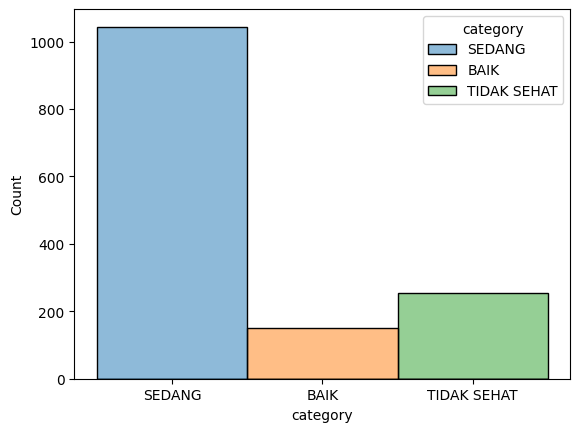

In [30]:
sns.histplot(
    data = dataset,
    x = "category",
    hue="category"
)
plt.show()

Secara visual juga terlihat jomplang / imbalance yang signifikan, apalagi tadi kita menggabungkan data `SEDANG` dengan `TIDAK SEHAT`. Jadi nanti di tahap pre-processing, kita akan melakukan **label balancing** entah itu di *undersampling* atau *oversampling*.

---

### 3.7 Outliers Check

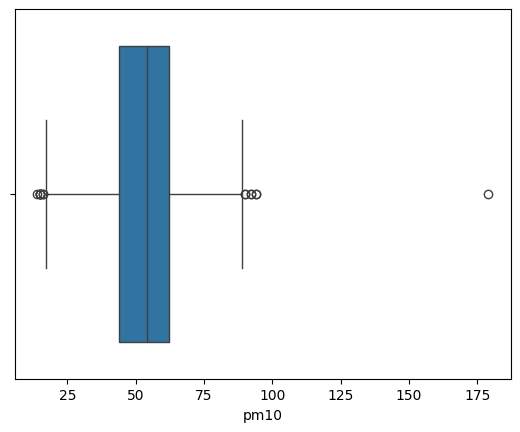

In [31]:
# pm10 boxplot

sns.boxplot(
    data = dataset,
    x = "pm10"
)
plt.show()

bisa dilihat, ada satu data yang nilainya terlalu besar di kanan sekitar diatas 175. 

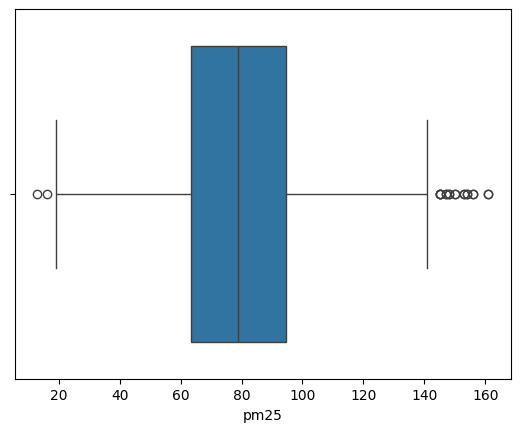

In [32]:
# pm25 boxplot

sns.boxplot(
    data = dataset,
    x = "pm25"
)
plt.show()

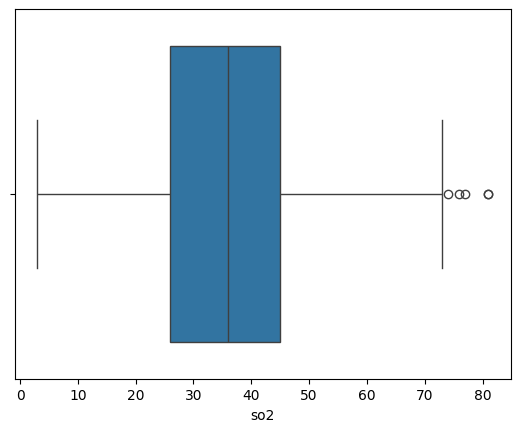

In [33]:
# so2 boxplot

sns.boxplot(
    data = dataset,
    x = "so2"
)
plt.show()

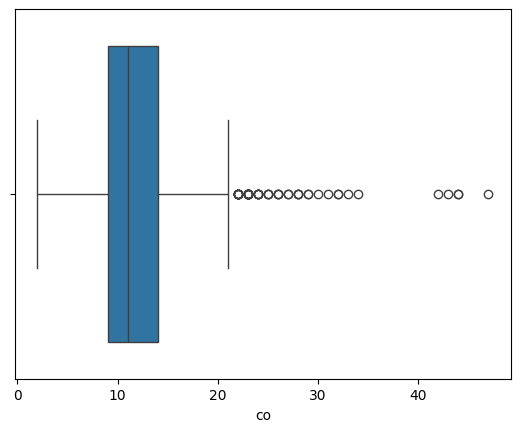

In [34]:
# co boxplot

sns.boxplot(
    data = dataset,
    x = "co"
)
plt.show()

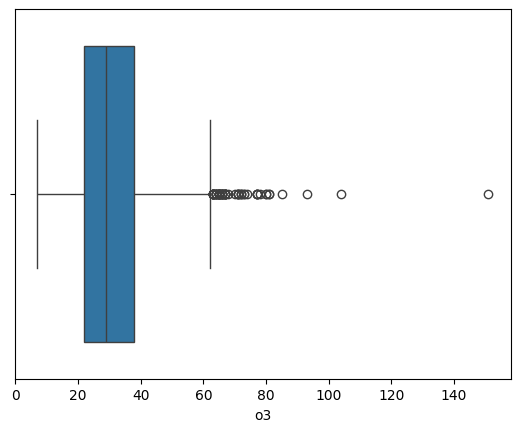

In [35]:
# o3 boxplot

sns.boxplot(
    data = dataset,
    x = "o3"
)
plt.show()

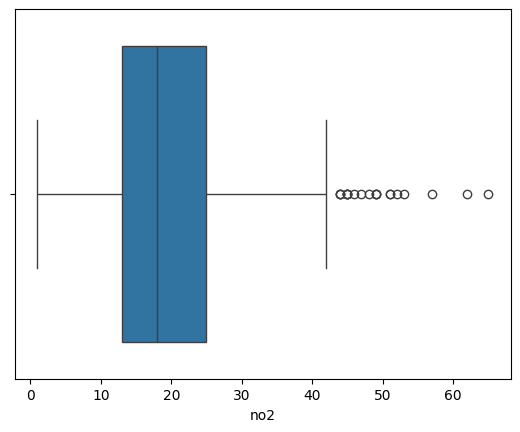

In [36]:
# no2 boxplot

sns.boxplot(
    data = dataset,
    x = "no2"
)
plt.show()

**Kesimpulan** :

1. Missing Value Handling :
   - `pm10`, `pm25` : class mean
   - `so2` : mean
   - `co`, `o3` dan `no2` : median 
2. Join label `SEDANG` dan `TIDAK SEHAT` menjadi `TIDAK BAIK`,
3. Label Balancing `BAIK` dan `TIDAK BAIK`,
4. Menhilangkan Outliers.